# 5. PCA (Principal Component Analysis)

In this exercise, we will work through several applications of PCA to the Ames dataset.

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
import seaborn as sns

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


In [2]:
def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i + 1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings

In [3]:
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

In [4]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [5]:
def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

In [6]:
data_path = "../../data/ames.csv.zip"

In [7]:
df = pd.read_csv(data_path)

In [8]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YearSold,SaleType,SaleCondition,SalePrice
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141.0,31770.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,None,0.0,5,2010,WD,Normal,215000
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80.0,11622.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,0.0,No_Pool,Minimum_Privacy,None,0.0,6,2010,WD,Normal,105000
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81.0,14267.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,Gar2,12500.0,6,2010,WD,Normal,172000
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93.0,11160.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,None,0.0,4,2010,WD,Normal,244000
4,Two_Story_1946_and_Newer,Residential_Low_Density,74.0,13830.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,0.0,No_Pool,Minimum_Privacy,None,0.0,3,2010,WD,Normal,189900


## 5.1 Find the highly correlated feature

Let's choose a few features that are highly correlated with our target, SalePrice.
Below function can find all feature that are correlated with our target column.

In [9]:
def get_corr_feature(df, target_col,min_score):
    feature_list=[]
    # as corrwith function only works on numeric columns, so we only check the correlation between numeric feature and SalePrice
    for feature in df.columns:
        if (df[feature].dtype == np.float64 or df[feature].dtype == np.int64):
            res = df[[feature]].corrwith(df[target_col])
            if res[0]>min_score:
                feature_list.append(feature)
                print(f"Correlation between {feature} and {target_col}: {res[0]}")
    return feature_list

In [10]:
feature_list=get_corr_feature(df,"SalePrice",0.5)

Correlation between YearBuilt and SalePrice: 0.5584261057120454
Correlation between YearRemodAdd and SalePrice: 0.5329737540266953
Correlation between MasVnrArea and SalePrice: 0.5021959770445459
Correlation between TotalBsmtSF and SalePrice: 0.6325288490320322
Correlation between FirstFlrSF and SalePrice: 0.6216760632702534
Correlation between GrLivArea and SalePrice: 0.7067799209766279
Correlation between FullBath and SalePrice: 0.5456039005201102
Correlation between GarageCars and SalePrice: 0.6475616131207702
Correlation between GarageArea and SalePrice: 0.6401382984873728
Correlation between SalePrice and SalePrice: 1.0


In [11]:
# you can notice the max value of correlation is 1.0
print(feature_list)

['YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'TotalBsmtSF', 'FirstFlrSF', 'GrLivArea', 'FullBath', 'GarageCars', 'GarageArea', 'SalePrice']


In [12]:
# For simplify things, we only choose four features
features = [
    "GarageArea",
    "YearRemodAdd",
    "TotalBsmtSF",
    "GrLivArea",
]

We'll rely on PCA to untangle the correlational structure of these features and suggest relationships that might be usefully modeled with new features.

In [13]:
X = df.copy()
y = X.pop("SalePrice")
X = X.loc[:, features]

X.head()

,GarageArea,YearRemodAdd,TotalBsmtSF,GrLivArea
0,528.0,1960,1080.0,1656.0
1,730.0,1961,882.0,896.0
2,312.0,1958,1329.0,1329.0
3,522.0,1968,2110.0,2110.0
4,482.0,1998,928.0,1629.0


In [14]:
# `apply_pca`, defined above, reproduces the code from the tutorial
pca, X_pca, loadings = apply_pca(X)
print(loadings)

                   PC1       PC2       PC3       PC4
GarageArea    0.541229  0.102375 -0.038470  0.833733
YearRemodAdd  0.427077 -0.886612 -0.049062 -0.170639
TotalBsmtSF   0.510076  0.360778 -0.666836 -0.406192
GrLivArea     0.514294  0.270700  0.742592 -0.332837


## 5.1 Interpret Component loadings

Look at the loadings for components PC1 and PC3. Can you think of a description of what kind of contrast each component has captured? After you've thought about it, run the next cell for a solution.


```text

The first component, PC1, seems to be a kind of "size" component, similar to what we saw in the tutorial: all of the features have the same sign (positive), indicating that this component is describing a contrast between houses having large values and houses having small values for these features.

The interpretation of the third component PC3 is a little trickier. The features GarageArea and YearRemodAdd both have near-zero loadings, so let's ignore those. This component is mostly about TotalBsmtSF and GrLivArea. It describes a contrast between houses with a lot of living area but small (or non-existant) basements, and the opposite: small houses with large basements.
```


Your goal in this question is to use the results of PCA to discover one or more new features that improve the performance of your model. One option is to create features inspired by the loadings, like we did in the tutorial. Another option is to use the components themselves as features (that is, add one or more columns of `X_pca` to `X`).

## 5.2 Create New Features

Add one or more new features to the dataset `X`. For a correct solution, get a validation score below 0.140 RMSLE.

Here, we illustre two possible solutions

### 5.2.1 Solution 1 Inspired by loadings


In [15]:
X_sol1 = df.copy()
y_sol1 = X_sol1.pop("SalePrice")


X_sol1["Feature1"] = X_sol1.GrLivArea + X_sol1.TotalBsmtSF
X_sol1["Feature2"] = X_sol1.YearRemodAdd * X_sol1.TotalBsmtSF


score_sol1 = score_dataset(X_sol1, y_sol1)
print(f"Your score: {score_sol1:.5f} RMSLE")


Your score: 0.13361 RMSLE


### 5.2.2 Solution 2 Uses components

In [19]:
X_sol2 = df.copy()
y_sol2 = X_sol2.pop("SalePrice")

X_pca.head()

,PC1,PC2,PC3,PC4
0,-0.165346,1.164936,0.233330,0.283527
1,-0.639050,0.649561,-0.622155,1.740770
2,-0.794227,1.175790,-0.580254,-0.551055
3,1.636658,1.907874,-0.675063,-1.052854
4,0.293648,-0.610856,0.342374,-0.047752


In [20]:
X_sol2 = X_sol2.join(X_pca)

In [18]:
score_sol2 = score_dataset(X_sol2, y_sol2)
print(f"Your score: {score_sol2:.5f} RMSLE")

Your score: 0.13707 RMSLE


## 5.3 Outlier Detection

We can also use PCA to detect outliers in the dataset (meaning, data points that are unusually extreme in some way). Outliers can have a detrimental effect on model performance, so it's good to be aware of them in case you need to take corrective action. PCA in particular can show you anomalous *variation* which might not be apparent from the original features: neither small houses nor houses with large basements are unusual, but it is unusual for small houses to have large basements. That's the kind of thing a principal component can show you.

Run the next cell to show distribution plots for each of the principal components you created above.

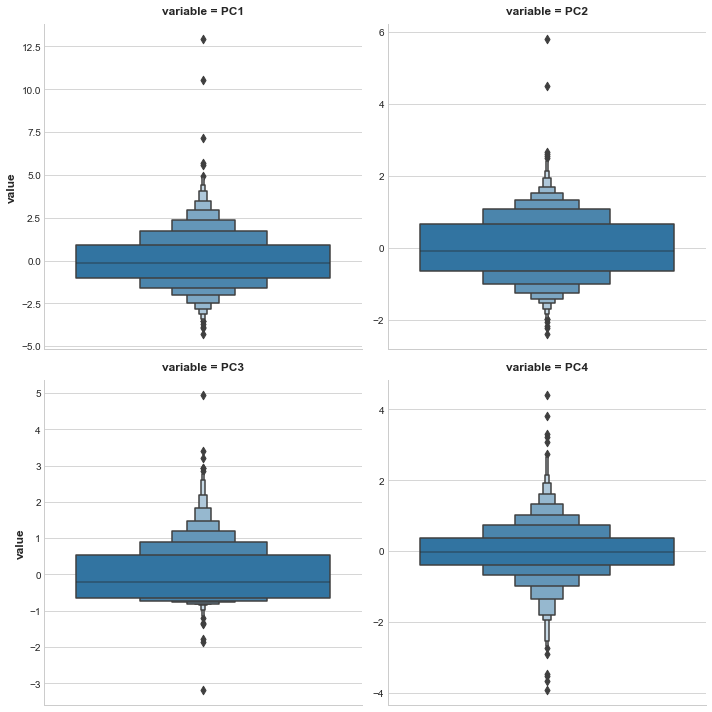

In [22]:
sns.catplot(
    y="value",
    col="variable",
    data=X_pca.melt(),
    kind='boxen',
    sharey=False,
    col_wrap=2,
);

As you can see, in each of the components there are several points lying at the extreme ends of the distributions -- outliers, that is.

Now run the next cell to see those houses that sit at the extremes of a component:

In [23]:
# You can change PC1 to PC2, PC3, or PC4
component = "PC1"

idx = X_pca[component].sort_values(ascending=False).index
df.loc[idx, ["SalePrice", "Neighborhood", "SaleCondition"] + features]

,SalePrice,Neighborhood,SaleCondition,GarageArea,YearRemodAdd,TotalBsmtSF,GrLivArea
1498,160000,Edwards,Partial,1418.0,2008,6110.0,5642.0
2180,183850,Edwards,Partial,1154.0,2009,5095.0,5095.0
2181,184750,Edwards,Partial,884.0,2008,3138.0,4676.0
1760,745000,Northridge,Abnorml,813.0,1996,2396.0,4476.0
1767,755000,Northridge,Normal,832.0,1995,2444.0,4316.0
...,...,...,...,...,...,...,...
662,59000,Old_Town,Normal,0.0,1950,416.0,599.0
2679,80500,Brookside,Normal,0.0,1950,0.0,912.0
2879,51689,Iowa_DOT_and_Rail_Road,Abnorml,0.0,1950,0.0,729.0
780,63900,Sawyer,Normal,0.0,1950,0.0,660.0


Do you notice any patterns in the extreme values? Does it seem like the outliers are coming from some special subset of the data?


Explanations:

```text
Notice that there are several dwellings listed as Partial sales in the Edwards neighborhood that stand out. A partial sale is what occurs when there are multiple owners of a property and one or more of them sell their "partial" ownership of the property.

These kinds of sales are often happen during the settlement of a family estate or the dissolution of a business and aren't advertised publicly. If you were trying to predict the value of a house on the open market, you would probably be justified in removing sales like these from your dataset -- they are truly outliers.
```

Pands tips: https://stackoverflow.com/questions/50302180/difference-between-dfx-dfx-dfx-dfx-and-df-x